# MLP - A Tensorflow-based Neural Network implementation

## All the imports

In [1]:
import nest_asyncio
nest_asyncio.apply()

import tensorflow_probability as tfp
tfd = tfp.distributions

import json
import os
import pathlib
import shutil

!export TF_CPP_MIN_LOG_LEVEL=3
!export TF_XLA_FLAGS=--tf_xla_enable_xla_devices

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import time
import random

# Activate TF2 behavior:
from tensorflow.python import tf2
if not tf2.enabled():
  import tensorflow.compat.v2 as tf
  tf.enable_v2_behavior() 
  assert tf2.enabled()

import numpy as np
import tensorflow as tf

# Set seeds
np.random.seed(10)
tf.random.set_seed(10)

from tensorflow.keras.layers import Input, Dense, LSTM, Lambda, Dropout, Flatten, Reshape, Conv2DTranspose
from tensorflow.keras.layers import Concatenate, Conv2D, UpSampling2D, MaxPooling2D, Conv3D, MaxPool3D, UpSampling3D, Conv3DTranspose

from tensorflow.keras import optimizers, models, regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model, Sequential, Model
from tensorflow.keras.regularizers import l1
from tensorflow.keras.utils import plot_model
from keras.losses import mse, binary_crossentropy



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

## GPU availability 

In [2]:
available_gpus = tf.config.list_physical_devices("GPU")
n_gpus = len(available_gpus)
if n_gpus > 1:
    n_gpus -= 1
is_gpu_available = n_gpus > 0

if is_gpu_available:
    print(f"{n_gpus} GPU{'s are' if n_gpus > 1 else ' is'} available.")
else:
    print("No GPU available")

1 GPU is available.


## Loading data

In [3]:
def load_data(fileIn):
    allFiles = np.loadtxt(fileIn)
    print('total files:' + str(allFiles.shape))
    
    X = allFiles[:, :6].astype('float32')
    y = allFiles[:, 6:].astype('float32')
    
    print(X.shape, y.shape)
    print('MIN: ', X.min(axis=0), y.min(axis=0))
    print('MAX: ', X.max(axis=0), y.max(axis=0))
    
    return X, y

In [4]:
# X, y = load_data('data/prop_spec_only.txt')
X, y = load_data('data/for_nesar_new.dat')

total files:(84917, 12)
(84917, 6) (84917, 6)
MIN:  [3.7346e-05 6.5085e-02 9.7260e+00 1.2784e+03 5.6973e+02 5.0248e-06] [7.2510e+01 8.9887e+03 7.8669e+03 1.2594e+04 2.7447e+03 1.6372e-01]
MAX:  [3.7434e-05 7.0573e-02 1.0131e+01 1.2983e+03 5.8374e+02 5.5886e-06] [1.1174e+02 1.1064e+04 1.0662e+04 2.7006e+04 2.8664e+03 5.4672e-01]


## Splitting dataset into training and testing

In [5]:
train_X, test_X, train_y, test_y = train_test_split(X, y[:,:], test_size=0.1, random_state=42)

In [6]:
valid_X = test_X
valid_y = test_y

In [7]:
print(f'train_X shape: {np.shape(train_X)}')
print(f'train_y shape: {np.shape(train_y)}')
print(f'valid_X shape: {np.shape(valid_X)}')
print(f'valid_y shape: {np.shape(valid_y)}')
print(f'test_X shape: {np.shape(test_X)}')
print(f'test_y shape: {np.shape(test_y)}')

train_X shape: (76425, 6)
train_y shape: (76425, 6)
valid_X shape: (8492, 6)
valid_y shape: (8492, 6)
test_X shape: (8492, 6)
test_y shape: (8492, 6)


In [8]:
print(X.min(axis=0))
print(X.max(axis=0))
print(y.min(axis=0))
print(y.max(axis=0))

[3.7346e-05 6.5085e-02 9.7260e+00 1.2784e+03 5.6973e+02 5.0248e-06]
[3.7434e-05 7.0573e-02 1.0131e+01 1.2983e+03 5.8374e+02 5.5886e-06]
[7.2510e+01 8.9887e+03 7.8669e+03 1.2594e+04 2.7447e+03 1.6372e-01]
[1.1174e+02 1.1064e+04 1.0662e+04 2.7006e+04 2.8664e+03 5.4672e-01]


## Distribution of inputs and outputs

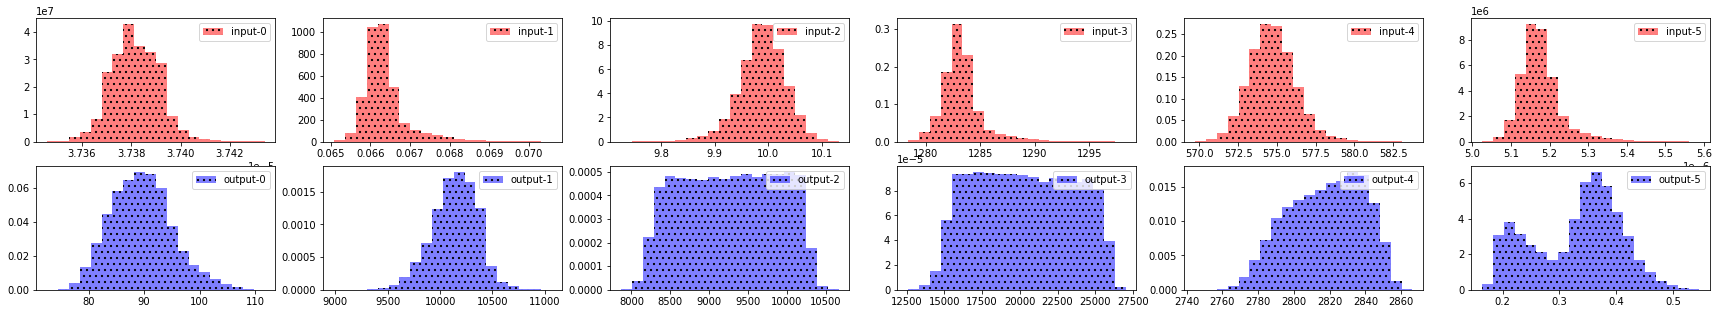

In [9]:
f, a = plt.subplots(2, train_X.shape[1], figsize=(train_X.shape[1]*5, 5))

for op in range(train_X.shape[1]):
    a[0, op].hist(X[:, op], bins=20, histtype='stepfilled', color='red', hatch='..', label='input-%d'%op, alpha=0.5, density=True);
    a[1, op].hist(y[:, op], bins=20, histtype='stepfilled', color='blue', hatch='..', label='output-%d'%op, alpha=0.5, density=True);
    a[0, op].legend()
    a[1, op].legend()

## Pre-processing the inputs and outputs

In [10]:
preprocessor_input = Pipeline([('stdscaler', StandardScaler()), ('minmax', MinMaxScaler(feature_range=(0, 1)))])
preprocessor_input.fit(train_X)
preprocessor_output = Pipeline([('stdscaler', StandardScaler()), ('minmax', MinMaxScaler(feature_range=(0, 1)))])
preprocessor_output.fit(train_y)

# preprocessor_input = Pipeline([('minmax', MinMaxScaler(feature_range=(0, 1)))])
# preprocessor_input.fit(train_X)
# preprocessor_output = Pipeline([('minmax', MinMaxScaler(feature_range=(0, 1)))])
# preprocessor_output.fit(train_y)


# preprocessor_input = Pipeline([('minmax', MinMaxScaler(feature_range=(0, 1))), ('stdscaler', StandardScaler())])
# preprocessor_input.fit(train_X)
# preprocessor_output = Pipeline([('minmax', MinMaxScaler(feature_range=(0, 1))), ('stdscaler', StandardScaler())])
# preprocessor_output.fit(train_y)


X_train = preprocessor_input.transform(train_X)
Y_train = preprocessor_output.transform(train_y)
X_val = preprocessor_input.transform(valid_X)
Y_val = preprocessor_output.transform(valid_y)
X_test = preprocessor_input.transform(test_X)
Y_test = preprocessor_output.transform(test_y)
print(X_train.shape)
print(Y_train.shape)

(76425, 6)
(76425, 6)


In [11]:
print(X_train.shape)
print(Y_train.shape)

(76425, 6)
(76425, 6)


In [12]:
train_invalid_indices = np.isnan(X_train).any(axis=1)
val_invalid_indices = np.isnan(X_val).any(axis=1)
test_invalid_indices = np.isnan(X_test).any(axis=1)

In [13]:
X_train = X_train[~train_invalid_indices]
Y_train = Y_train[~train_invalid_indices]
X_val = X_val[~val_invalid_indices]
Y_val = Y_val[~val_invalid_indices]
X_test = X_test[~test_invalid_indices]
Y_test = Y_test[~test_invalid_indices]

In [14]:
train_idx = random.sample(range(X_train.shape[0]),X_train.shape[0])
val_idx = random.sample(range(X_val.shape[0]),X_val.shape[0])

In [15]:
def load_data_train_valid(verbose=0, random_state=42):
    
    #X_train = ray.get(X_train_id)
    #Y_train = ray.get(Y_train_id)
    #X_val = ray.get(X_val_id)
    #Y_val = ray.get(Y_val_id)
    #X_test = ray.get(X_test_id)
    #Y_test = ray.get(Y_test_id)
    
    train_X, valid_X, train_y, valid_y = X_train[train_idx],  X_val[val_idx], Y_train[train_idx], Y_val[val_idx]

    if verbose:
        print(f'train_X shape: {np.shape(train_X)}')
        print(f'train_y shape: {np.shape(train_y)}')
        print(f'valid_X shape: {np.shape(valid_X)}')
        print(f'valid_y shape: {np.shape(valid_y)}')
    return (train_X, train_y), (valid_X, valid_y)



## Setting neural network hyper-parameters

In [16]:
num_epochs = 300
batch_size = 2048 #4 #256
learning_rate = 1e-3 #1e-4
decay_rate = 0.0
mode = 'train'

## Defining Network architecture

In [17]:
###### mlp  ###################

nn_inputs = Input(shape=(X_train.shape[1]),name='Field')

# x= Flatten()(nn_inputs)
x= Dense(128)(nn_inputs)   ###### added new
x= Dense(256, activation='relu')(x)  ###### added new
x= Dense(256, activation='relu')(x)   ###### added new
x= Dense(1024, activation='relu')(x)   ###### added new
x= Dense(2048, activation='relu')(x)   ###### added new
x= Dense(1024, activation='relu')(x)   ###### added new
x= Dense(256, activation='relu')(x)   ###### added new
x= Dense(256, activation='relu')(x)   ###### added new
x= Dense(128, activation='relu')(x)   ###### added new
x= Dense(Y_train.shape[1], activation='relu')(x)   ###### added new

nn_model = Model(inputs=nn_inputs, outputs=x)

nn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Field (InputLayer)          [(None, 6)]               0         
                                                                 
 dense (Dense)               (None, 128)               896       
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 1024)              263168    
                                                                 
 dense_4 (Dense)             (None, 2048)              2099200   
                                                                 
 dense_5 (Dense)             (None, 1024)              209817

In [18]:
nn_model.compile(optimizer='nadam', loss='mae') # for Vanilla AE

K.set_value(nn_model.optimizer.lr, learning_rate)
K.set_value(nn_model.optimizer.decay, decay_rate)
# nn_model.summary()

## Training phase

In [19]:
folder = './model/'
weights_filepath = folder + 'best_weights_nn_pca.h5'
time0 = time.time()
if mode == 'train':
    checkpoint = ModelCheckpoint(weights_filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='min',save_weights_only=True)
    earlystopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=300, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
    callbacks_list = (checkpoint,earlystopping)
    
    train_history = nn_model.fit(x=X_train, y=Y_train, epochs=num_epochs, batch_size=batch_size, callbacks=callbacks_list, validation_split=0.1, verbose=0)
        
    nn_model.save_weights(folder + 'pca_nn')
    print('Training complete')
    
time1 = time.time()

Training complete


## Loss vs epoch curve

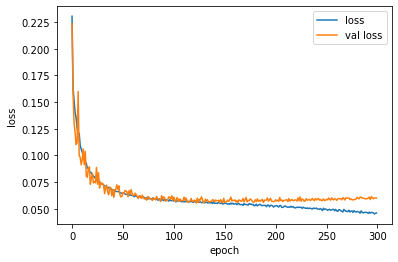

In [20]:
if mode == 'train':
    plt.figure(2111)
    plt.plot(train_history.history['loss'], label = 'loss')
    plt.plot(train_history.history['val_loss'], label = 'val loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

## Load a trained model

In [21]:
# trained_model = Model(inputs=encoder_inputs, outputs=ae_outputs, name='VAE')
nn_model.load_weights(weights_filepath)
nn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Field (InputLayer)          [(None, 6)]               0         
                                                                 
 dense (Dense)               (None, 128)               896       
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 1024)              263168    
                                                                 
 dense_4 (Dense)             (None, 2048)              2099200   
                                                                 
 dense_5 (Dense)             (None, 1024)              209817

## Prediction from a trained model

In [22]:
Y_pred = nn_model.predict(X_test)
# Y_pred = preprocessor_output.inverse_transform(Y_pred)

266/266 [==============================] - 0s 821us/step


## True vs Prediction plots

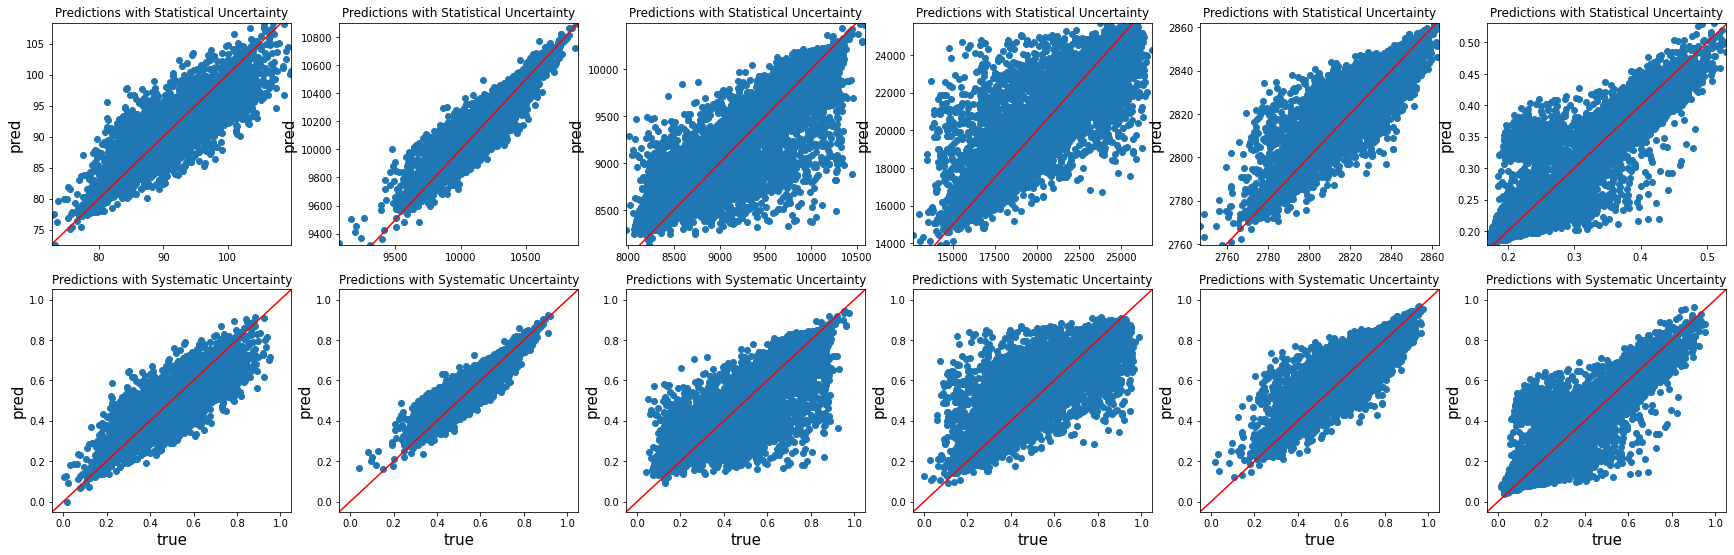

In [23]:
f, a = plt.subplots(2, Y_train.shape[1], figsize=(Y_train.shape[1]*5, 9))

########

for plot_id in range(Y_train.shape[1]):


    a[0, plot_id].title.set_text('Predictions with Statistical Uncertainty')
    a[0, plot_id].set_ylabel('pred', fontsize=15)
    a[0, plot_id].axline([0, 0], [1, 1], color = 'r')
    a[0, plot_id].set_xlim(preprocessor_output.inverse_transform(Y_test)[:, plot_id].min(), preprocessor_output.inverse_transform(Y_test)[:, plot_id].max())
    a[0, plot_id].set_ylim(preprocessor_output.inverse_transform(Y_pred)[:, plot_id].min(), preprocessor_output.inverse_transform(Y_pred)[:, plot_id].max())

    a[0, plot_id].scatter(preprocessor_output.inverse_transform(Y_test)[:, plot_id], preprocessor_output.inverse_transform(Y_pred)[:, plot_id])


    ########



    a[1, plot_id].title.set_text('Predictions with Systematic Uncertainty')
    a[1, plot_id].set_xlabel('true', fontsize=15)
    a[1, plot_id].set_ylabel('pred', fontsize=15)
    a[1, plot_id].axline([0, 0], [1, 1], color = 'r')
    
    # a[1, plot_id].set_xlim(Y_test[:, plot_id].min(), Y_test[:, plot_id].max())
    # a[1, plot_id].set_ylim(Y_pred[:, plot_id].min(), Y_pred[:, plot_id].max())
    a[1, plot_id].scatter(Y_test[:, plot_id], Y_pred[:, plot_id])


plt.savefig('plots/dh_test')
# plt.show()

## Saving outputs

In [24]:
testing_data_op = preprocessor_output.inverse_transform(Y_test)
testing_data_pred = preprocessor_output.inverse_transform(Y_pred)

for op in range(Y_train.shape[1]):
    var_true = testing_data_op[:,op]
    var_pred = testing_data_pred[:,op]

    pdiff = abs((var_true - var_pred)*200/(var_true+var_pred))

    # np.savetxt('pdiff_var'+ str(op) + '.dat',pdiff,delimiter='  ',fmt='%12.5G')
    # np.savetxt('testvar_'+ str(op) + '.dat',testing_data_op[:,op],delimiter='  ',fmt='%12.5G')
    # np.savetxt('predvar_'+ str(op) + '.dat',testing_data_pred[:,op],delimiter='  ',fmt='%12.5G')

    dat = np.array([testing_data_op[:,op],testing_data_pred[:,op],pdiff])
    dat = dat.T
    np.savetxt('out/true_pred_diff_'+ str(op) + '.dat', dat ,delimiter='  ',fmt='%12.5G')

## Difference between true and pred

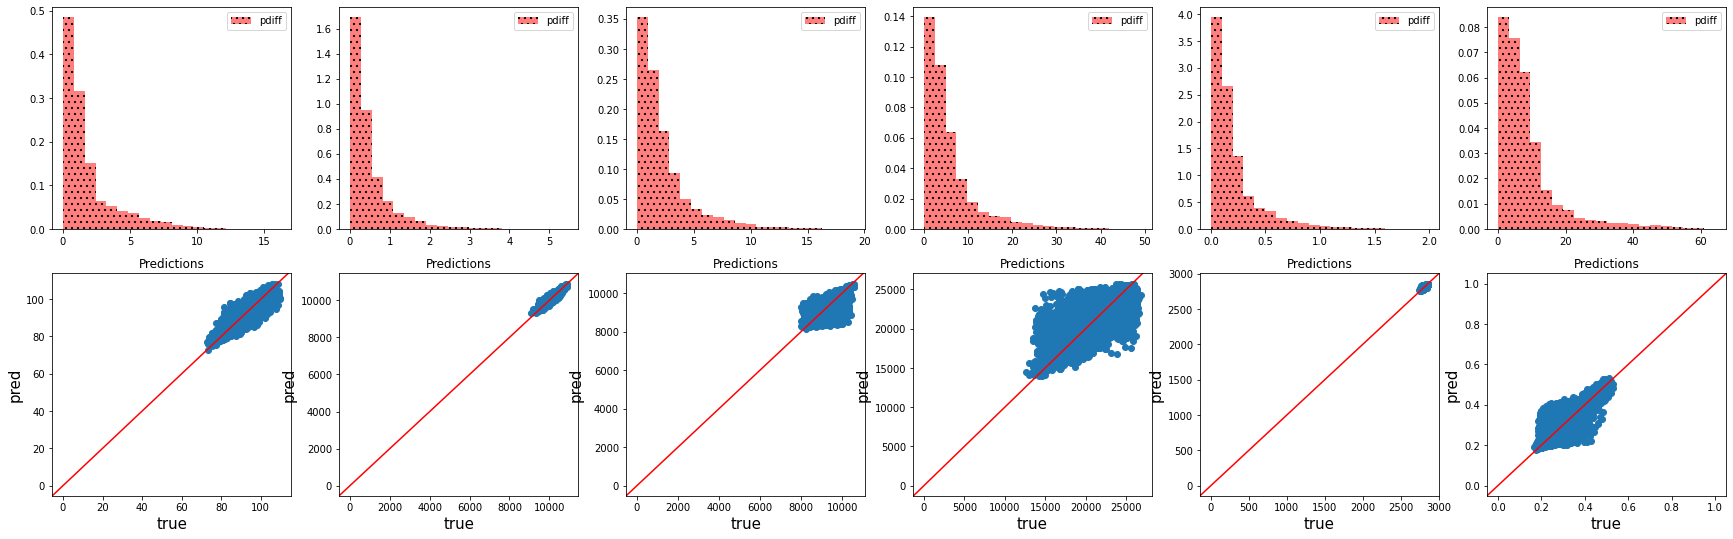

In [25]:
f, a = plt.subplots(2, Y_train.shape[1], figsize=(Y_train.shape[1]*5, 9))

for op in range(Y_train.shape[1]):
    load_dat = np.loadtxt('out/true_pred_diff_'+ str(op) + '.dat')
    a[0, op].hist(load_dat[:, 2], bins=20, histtype='stepfilled', color='red', hatch='..', label='pdiff', alpha=0.5, density=True);
    a[0, op].legend()
    
    
    a[1, op].scatter(load_dat[:, 0], load_dat[:, 1])
    a[1, op].title.set_text('Predictions')
    a[1, op].set_xlabel('true', fontsize=15)
    a[1, op].set_ylabel('pred', fontsize=15)
    a[1, op].axline([0, 0], [1, 1], color = 'r')
    
    
plt.savefig('plots/pdiff_hist')

## Training (depends on epochs and batch size) and inference time

In [30]:
time2 = time.time()

Y_pred = nn_model.predict(X_test);
preprocessor_output.inverse_transform(Y_test);

time3 = time.time()


print('Training time: %.2f minutes for a total of %d epochs and %d batch size'%( (time1-time0)/60., num_epochs, batch_size) )
print('Inference time: %.4f minutes for a total of %d testing samples'%( (time3-time2)/60., X_test.shape[0]))

266/266 [==============================] - 0s 844us/step
Training time: 0.94 minutes for a total of 300 epochs and 2048 batch size
Inference time: 0.0051 minutes for a total of 8492 testing samples


## Summary of the bias

Output dimension: 0
90.7: pdiff < 5 
8.7: 5 < pdiff < 10 
0.7: pdiff > 10 

=*=*=*=*=*
Output dimension: 1
100.0: pdiff < 5 
0.0: 5 < pdiff < 10 
0.0: pdiff > 10 

=*=*=*=*=*
Output dimension: 2
89.1: pdiff < 5 
9.1: 5 < pdiff < 10 
1.7: pdiff > 10 

=*=*=*=*=*
Output dimension: 3
61.6: pdiff < 5 
23.4: 5 < pdiff < 10 
15.0: pdiff > 10 

=*=*=*=*=*
Output dimension: 4
100.0: pdiff < 5 
0.0: 5 < pdiff < 10 
0.0: pdiff > 10 

=*=*=*=*=*
Output dimension: 5
40.3: pdiff < 5 
32.5: 5 < pdiff < 10 
27.2: pdiff > 10 

=*=*=*=*=*


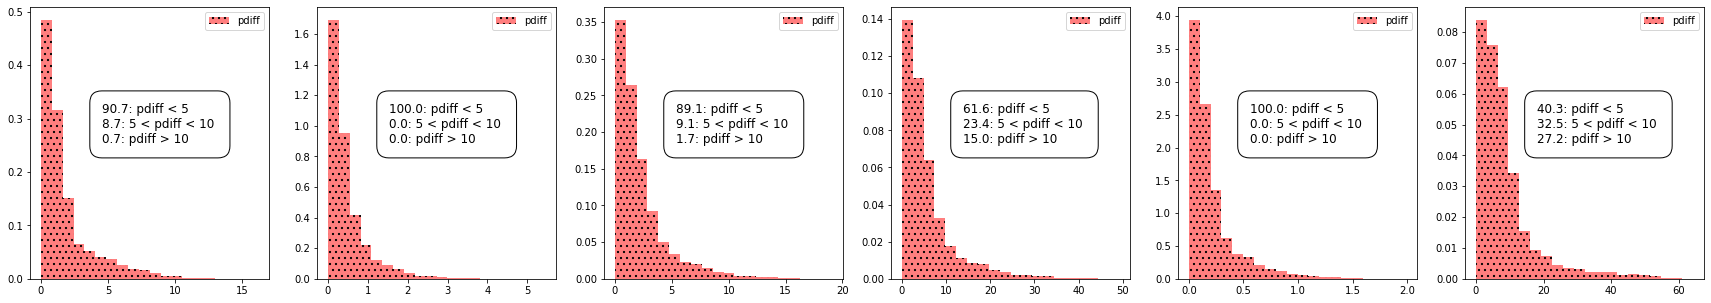

In [74]:
f, a = plt.subplots(1, Y_train.shape[1], figsize=(Y_train.shape[1]*5, 5))


for op in range(Y_train.shape[1]):
    load_dat = np.loadtxt('out/true_pred_diff_'+ str(op) + '.dat')
    pdiff = load_dat[:, 2]
    lim5 = np.array(np.where(pdiff < 5)).shape[1]
    lim5_10 = np.array(np.where(pdiff < 10)).shape[1] - lim5
    lim_rest = pdiff.shape[0] - (lim5_10 + lim5)
    
    print('Output dimension: %d'%op)
    # print( '%.1f under 5 percent'%(100*lim5/pdiff.shape[0]))
    # print( '%.1f in 5-10 percent'%(100*lim5_10/pdiff.shape[0]))
    # print( '%.1f over 10 percent'%(100*lim_rest/pdiff.shape[0]))

    

    a[op].hist(load_dat[:, 2], bins=20, histtype='stepfilled', color='red', hatch='..', label='pdiff', alpha=0.5, density=True);
    a[op].legend()
    
    plttxt = '%.1f: pdiff < 5 '%(100*lim5/pdiff.shape[0]) + '\n' + '%.1f: 5 < pdiff < 10 '%(100*lim5_10/pdiff.shape[0]) + '\n' + '%.1f: pdiff > 10 '%(100*lim_rest/pdiff.shape[0])
    print(plttxt)
    # a[op].text(x=0.5, y = 0.4, s ='%.1f pdiff < 5 '%(100*lim5/pdiff.shape[0]), transform=a[op].transAxes)
    # a[op].text(x=0.5, y = 0.5, s ='%.1f 5 < pdiff < 10 '%(100*lim5_10/pdiff.shape[0]), transform=a[op].transAxes)
    # a[op].text(x=0.5, y = 0.6, s ='%.1f pdiff > 10 '%(100*lim_rest/pdiff.shape[0]), transform=a[op].transAxes)
    
    a[op].text(x=0.3, y = 0.5, s =plttxt, size=12, transform=a[op].transAxes, bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=1'))

    print('')
    print(5*'=*')
    
    